# 선박 도장 품질 분류 모델 개발 프로젝트

## 목차
1. [프로젝트 개요 및 개발 전략](#sec-1)
2. [탐색적 데이터 분석 (EDA)](#sec-2)
3. [데이터 전처리 및 증강](#sec-3)
4. [모델링 및 학습](#sec-4)
5. [평가 및 결과](#sec-5)
6. [결론 및 제언](#sec-6)

<a id="sec-1"></a>
## 1. 프로젝트 개요 및 개발 전략

### 1.1 문제 정의
이번 프로젝트는 선박 도장의 품질을 자동으로 검사하여 양품과 4가지 결함 유형을 분류하는 **다중 클래스 분류 문제**입니다.

### 1.2 팀 협업 전략

#### Git 브랜치 전략
저희 팀은 **안정적인 코드 관리 및 리뷰**와 **효율적인 협업**을 위해 다음과 같은 전략을 수립했습니다:
- **Main Branch 보호**: main 브랜치 직접 푸시 금지로 검증되지 않은 코드 병합 방지
- **최소한의 파일 관리**: `code.ipynb`, `changelog.md` 등 핵심 파일만 버전 관리
- **Feature Branch 워크플로우**: 독립적인 브랜치 개발 후 코드 리뷰를 거쳐 병합
- **branch convention, commit convention 정의**: git 사용에 명백한 convention을 정의함으로서 잘못된 파일 관리 전략을 사용하는 등의 혼란을 최소화
- **KISS 원칙에 따른 복잡하지 않은 git 전략**: 대회는 짧고, 짧은 기간안에 숙지 가능한 전략만 제시해야 합니다.

#### Arena 방식 개발
이미지 경진대회의 특징에 대해 다시 생각해봅시다. 저희 팀의 이하나님께서 전회차 분류 경진대회에서 개인으로 참가해 1위를 차지한 사실로 알 수 있듯이 모델 개발 프로세스 자체는 혼자서도 진행할 수 있는 일입니다.

우리는 흔히 팀 플레이라고 하면 **분업**의 형태를 많이 떠올립니다. 각자 잘하는것을 맡아 하자는거죠. 하지만 앞서 언급했듯이 모델 개발 프로세스는 혼자서도 모든 작업을 감당 가능한 작은 태스크이고 이렇게 작은 규모의 태스크에서 분업이 큰 의미가 있을지에 대해 회의감을 느꼈고, 팀원들의 역량 또한 각각이 혼자서 모델을 개발하기에 충분히 유능하신 분들이기 때문에 계획 단계에서 Arena 방식을 고안했습니다. 각자 다른 모델을 맡아 개발하고, 가장 높은 성능을 보인 팀원의 코드를 채택하는 것이죠.

따라서 **경쟁적 협업 방식**을 통해 최고의 성능을 달성하고자 했습니다:
- 각 팀원이 서로 다른 모델 아키텍처를 병렬적으로 개발
- 주기적 성능 비교 후 최고 성능 모델 채택
- 최고 성능 달성 팀원이 PR 요청, 팀장 리뷰 후 병합

### GPU 상태 확인: nvidia-smi

`nvidia-smi` 명령어는 현재 사용 가능한 NVIDIA GPU의 상태(메모리 사용량, GPU 사용률, 드라이버 버전 등)를 확인하기 위해 사용합니다. 딥러닝 모델 학습 전후로 GPU 리소스가 정상적으로 할당되어 있는지, 메모리 부족(OOM) 문제가 없는지 점검하는 데 유용합니다.

In [1]:
!nvidia-smi

Wed Aug 20 00:22:40 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                   On |
| N/A   46C    P0             130W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

그리고 라이브러리를 설치합니다. 전체 재실행이 필요할 경우 Ctrl + /를 써서 주석처리 하면 불편함 없이 재실행이 가능하겠네요.

In [3]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.
!pip install --upgrade pip
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install opencv-python
!sudo apt-get update
!sudo apt-get install libgl1-mesa-glx -y
!pip install albumentations
!pip install timm
!pip install transformers
!pip install nbformat

### 라이브러리 임포트
필요한 모든 라이브러리를 임포트합니다. 각 라이브러리의 역할은 다음과 같습니다:
- **기본 라이브러리**: 파일 처리, 데이터 조작을 위한 os, numpy, pandas
- **이미지 처리**: PIL, OpenCV를 통한 이미지 읽기 및 전처리
- **딥러닝 프레임워크**: PyTorch 및 관련 모듈
- **모델 라이브러리**: timm을 통한 최신 비전 모델 활용
- **데이터 증강**: Albumentations를 통한 강력한 이미지 증강

In [4]:
# --- 기본 및 데이터 처리 라이브러리 ---
import os  # 운영체제와 상호작용하기 위한 라이브러리 (파일 경로 등)
import random  # 무작위 샘플링 및 시드 고정을 위해 사용
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import cv2  # OpenCV, 이미지 파일을 읽고 처리하기 위한 라이브러리
import math

# --- 딥러닝(PyTorch) 관련 라이브러리 ---
import torch  # PyTorch 핵심 라이브러리
import torch.nn as nn  # 신경망 모델의 레이어나 손실 함수 등을 포함
from torch.utils.data import Dataset, DataLoader  # 커스텀 데이터셋과 데이터 로더를 위한 클래스
import torchvision.transforms.functional as F

# --- PyTorch 최적화 및 스케줄러 ---
from torch.optim import AdamW  # Adam Optimizer의 개선된 버전, 딥러닝에서 널리 사용됨
from transformers import get_linear_schedule_with_warmup  # 학습률을 점진적으로 조정하는 스케줄러

# --- 이미지 증강 라이브러리 ---
import albumentations as A  # 빠르고 다양한 이미지 증강 기법을 제공하는 라이브러리
from albumentations.pytorch import ToTensorV2  # Albumentations 출력을 PyTorch 텐서로 변환

# --- 최신 이미지 모델 라이브러리 ---
import timm  # PyTorch Image Models, 거의 모든 최신 비전 모델을 쉽게 사용할 수 있게 해주는 라이브러리

# --- 진행 상황 시각화 ---
from tqdm.auto import tqdm  # for문 등 반복문의 진행 상황을 시각적으로 보여주는 라이브러리 (주피터 노트북용)

# --- 머신러닝 및 평가 라이브러리 ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


# --- 시각화 및 한글 설정 ---
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
plt.style.use('default')
mpl.rc("font", family="NanumGothic") # Linux
# mpl.rc("font", family="AppleGothic") # Mac
# mpl.rc("font", family="Malgun Gothic") # Windows
plt.rcParams["axes.unicode_minus"] = False
%matplotlib inline


## Configuration

### 하이퍼파라미터 설정
모든 실험 설정을 중앙에서 관리하기 위해 CFG 딕셔너리를 사용합니다. 이를 통해 실험의 **재현성**과 **일관성**을 보장할 수 있습니다.

실험을 통해 다음과 같은 최적 하이퍼파라미터를 도출했습니다:
- **이미지 크기**: 224x224 (128 대비 성능 향상)
- **배치 크기**: 16 (GPU 메모리 고려)
- **에폭**: 10 (사전 Train-Validation History 기록을 참고한 최적의 에폭 선정)
- **학습률**: 1e-4 (안정적 수렴)

In [5]:
# 모든 하이퍼파라미터와 설정을 이곳에서 관리합니다.
CFG = {
    # --- 기본 설정 ---
    "ROOT": Path("/mnt/elice/dataset/"),
    "SEED": 42,  # 재현성을 위한 랜덤 시드
    "DEVICE": torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    ),  # GPU 사용 가능 여부에 따라 디바이스 설정
    # --- 학습 파라미터 ---
    "IMG_SIZE": 224,  # 모델에 입력될 이미지의 크기 (가로, 세로)
    "EPOCHS": 10,  # 전체 데이터셋을 총 몇 번 학습할 것인지 (에폭)
    "LEARNING_RATE": 1e-4,  # 학습률. 모델이 얼마나 큰 폭으로 파라미터를 업데이트할지 결정
    "BATCH_SIZE": 16,  # 한 번의 반복(iteration)에서 모델에 입력할 데이터의 개수
    "NUM_CLASSES": 5, # 클래스 개수 설정 
}

print("✅ 환경설정 완료!")
print(f"사용할 디바이스: {CFG['DEVICE']}")

✅ 환경설정 완료!
사용할 디바이스: cuda


## Utils

### 재현성을 위한 시드 고정
딥러닝 실험의 재현성은 매우 중요하지만 CUDA 연산의 비결정성으로 인해 매번 동일한 결과를 기대하긴 어렵습니다. 처음에는 가능한 한 F1 score 또한 매 실행에 맞춰 동일하게 나오도록 deterministric한 전략을 사용하였으나 CUDA의 비결정적 연산, Kaggle 등의 대형 데이터 경진대회의 규정에서도 error에 대한 기준이 없는 점, 결정론적 전략을 채택할 경우 일어나는 성능 저하 등의 문제로 인해 **시드 고정** 전략만 재현성을 위해 구현하기로 결정했습니다.

> **더 보기**: CUDA의 비결정적 연산 원인:
> 1. **병렬 연산의 순서 불확정성**
>    - GPU는 수천 개의 코어가 동시에 작동
>    - 부동소수점 덧셈은 결합법칙이 성립하지 않음
>    - (a + b) + c ≠ a + (b + c) in floating point
>
> 2. **최적화된 알고리즘 사용**
>    - cuDNN은 속도를 위해 다양한 최적화 기법 사용
>    - 동일한 연산도 상황에 따라 다른 알고리즘 선택
>
> 3. **Atomic Operations**
>    - 여러 스레드가 동시에 메모리 접근
>    - 접근 순서가 매번 달라질 수 있음


In [6]:
# 랜덤 시드 고정
def set_seed(seed=42):
    random.seed(seed)  # 파이썬 표준 난수 시드
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)  # Numpy 난수 시드
    torch.manual_seed(seed)  # PyTorch CPU 연산 난수 시드
    torch.cuda.manual_seed(seed)  # CUDA 단일 GPU 난수 시드
    torch.cuda.manual_seed_all(seed)  # CUDA 다중 GPU 난수 시드
    torch.backends.cudnn.deterministic = True  # CuDNN 연산을 결정론적으로 고정
    torch.backends.cudnn.benchmark = False  # 입력 크기 탐색 비활성화
    
    # non-deterministic 연산이 실행되려 하면 에러 발생시켜주는 기능
    torch.use_deterministic_algorithms(True)
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

set_seed(CFG["SEED"])
print(f"✅ 시드({CFG['SEED']}) 고정 완료!")

✅ 시드(42) 고정 완료!


## 데이터 불러오기

### 데이터 구조 파악
학습 데이터는 6개 폴더에 나뉘어 저장되어 있으며 각 폴더명이 해당 이미지들의 라벨을 나타냅니다. 양품의 경우 선수와 외판 두 종류가 있으며 설정에 따라 병합 처리할수도, 분리 처리할수도 있습니다.


In [7]:
# 폴더명과 라벨을 매핑하는 딕셔너리
if CFG["NUM_CLASSES"] == 5:
    folder_to_label = {
        "TS_도막 손상_스크래치": "스크래치",
        "TS_도장 불량_부풀음": "부풀음",
        "TS_도막 손상_도막떨어짐": "도막떨어짐",
        "TS_도장 불량_이물질포함": "이물질포함",
        "TS_양품_선수": "양품",
        "TS_양품_외판": "양품",
    }
else:
    folder_to_label = {
        "TS_도막 손상_스크래치": "스크래치",
        "TS_도장 불량_부풀음": "부풀음",
        "TS_도막 손상_도막떨어짐": "도막떨어짐",
        "TS_도장 불량_이물질포함": "이물질포함",
        "TS_양품_선수": "양품선",  # 양품_선수, 양품_외판 클래스 따로 분리
        "TS_양품_외판": "양품외",
    }
    
# 학습/검증 데이터 이미지 파일의 경로와 라벨을 저장할 리스트를 만듬.
train_image_data = []
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 각 폴더를 순회하며 파일 경로와 라벨을 가져옴.
for folder_name, label in folder_to_label.items():
    folder_path = CFG["ROOT"] / folder_name
    # 폴더와 하위 폴더의 모든 파일을 확인하면서 확장자를 검사.
    for image_path in folder_path.rglob("*"):
        if image_path.is_file() and image_path.suffix.lower() in IMG_EXTS:  # 확장자가 IMG_EXTS에 있으면
            train_image_data.append({"path": str(image_path), "label": label})

# 리스트를 판다스 DataFrame으로 변환.
df = pd.DataFrame(train_image_data)

print(f"전체 이미지 개수 (훈련 + 검증): {len(df)}")
display(df.head())

# 테스트 데이터 이미지 경로를 저장할 리스트를 만듬.
test_image_data = []
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_data.append({"path": str(p)})

# 테스트 이미지 데이터를 DataFrame으로 변환.
df_test = pd.DataFrame(test_image_data)

print(f"\n전체 이미지 개수 (테스트): {len(df_test)}")
display(df_test.head())

전체 이미지 개수 (훈련 + 검증): 1200


path label
0  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_24f2ae...  스크래치
1  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_23b33b...  스크래치
2  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_20c5f1...  스크래치
3  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_34b46d...  스크래치
4  /mnt/elice/dataset/TS_도막 손상_스크래치/302_15_42fa37...  스크래치


전체 이미지 개수 (테스트): 1000


path
0  /mnt/elice/dataset/제출용 데이터/00304.jpg
1  /mnt/elice/dataset/제출용 데이터/00765.jpg
2  /mnt/elice/dataset/제출용 데이터/00013.jpg
3  /mnt/elice/dataset/제출용 데이터/00472.jpg
4  /mnt/elice/dataset/제출용 데이터/00800.jpg

<a id="sec-2"></a>
## 2. 탐색적 데이터 분석 (EDA)

# 선박 도장 품질 분류 모델 개발을 위한 EDA 분석 보고서

### 핵심 발견사항
- **데이터셋 규모**: 총 1,200개의 다양한 크기 분포를 가진 이미지
- **클래스 분포**: 양품 2개, 4가지 결함 유형 각 16.7%로 완벽한 균형
- **이미지 품질**: 육안 검사 결과 범주별 특징이 뚜렷하고 노이즈가 적음

### 주요 권장사항
EDA를 통해 도출한 핵심 인사이트는 다음과 같습니다:
1. **균형잡힌 데이터셋**: 클래스 불균형이 없으므로 별도의 샘플링 전략 불필요
2. **고해상도 활용**: 평균 2700x2200의 고해상도를 효과적으로 활용할 전략 필요
3. **적극적 증강**: 1,200개의 제한된 데이터로 인한 과적합 방지 필수

## 1. 데이터셋 개요

### 1.1 문제 정의
선박 도장의 품질을 자동으로 검사하여 양품과 4가지 결함 유형을 분류하는 다중 클래스 분류 문제입니다.

### 1.2 데이터 구조
```
총 데이터: 1,200개 이미지
데이터 타입: float32 (0-1 정규화)
저장 구조: 6개 폴더 (양품 2개, 결함 4개)
```

### 1.3 클래스 정의
| 원본 폴더명 | 분류 라벨 | 카테고리 |
|------------|----------|----------|
| TS_양품_선수, TS_양품_외판 | 양품 | 정상 |
| TS_도막 손상_스크래치 | 스크래치 | 결함 |
| TS_도장 불량_부풀음 | 부풀음 | 결함 |
| TS_도막 손상_도막떨어짐 | 도막떨어짐 | 결함 |
| TS_도장 불량_이물질포함 | 이물질포함 | 결함 |

## 2. 데이터 분포 분석

### 2.1 클래스 불균형 현황

각 Class의 **도수**와 **비율**을 확인하고 싶으므로 여기서는 **파이 차트**를 사용하도록 하겠습니다.
비중이 직관적으로 들어오기 때문에 확인하기 쉽습니다.

```
양품_선수, 양품_외판: 각각 200개 (16.7% x 2)
스크래치: 200개 (16.7%)
부풀음: 200개 (16.7%)
도막떨어짐: 200개 (16.7%)
이물질포함: 200개 (16.7%)
```

아울러 이미지 특징을 전체적으로 탐색하며 분석이 정확한지 다시 한번 살펴보겠습니다.

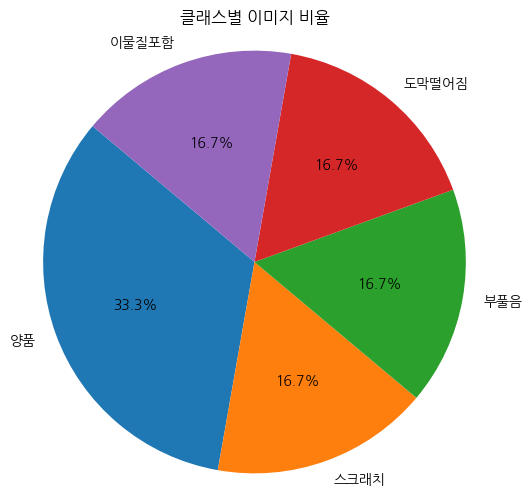

In [8]:
# 클래스별 이미지 개수 확인
plt.figure(figsize=(6,6)) 
# 파이 차트 생성
# value_counts()로 각 클래스별 개수를 얻고, index로 라벨 이름을 얻음
counts = df["label"].value_counts()
plt.pie(counts, labels=counts.index, autopct="%1.1f%%", startangle=140)
plt.title("클래스별 이미지 비율")
plt.axis("equal")
plt.show()
# 모든 클래스 이미지 200개씩 같음

--- [ 스크래치 ] 이미지 샘플 ---


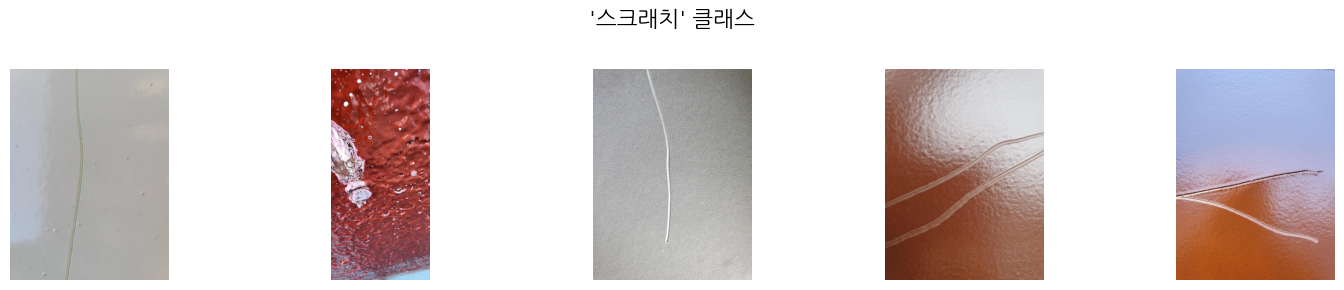



--- [ 부풀음 ] 이미지 샘플 ---


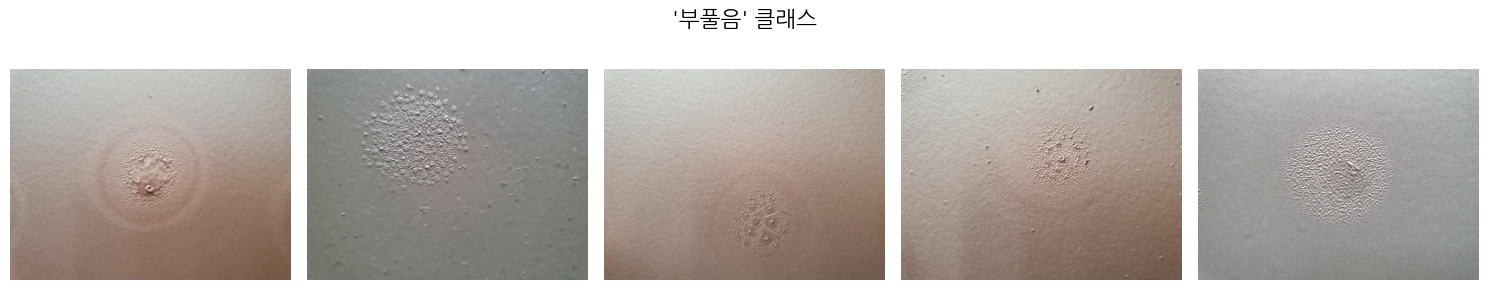



--- [ 도막떨어짐 ] 이미지 샘플 ---


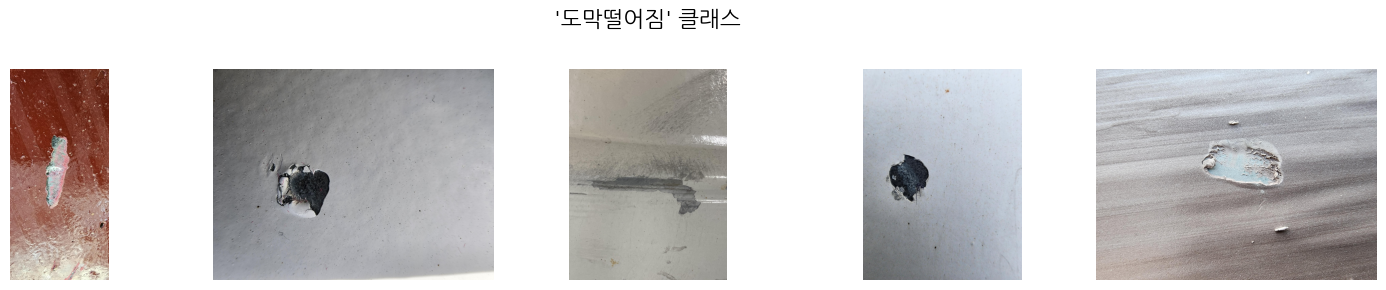



--- [ 이물질포함 ] 이미지 샘플 ---


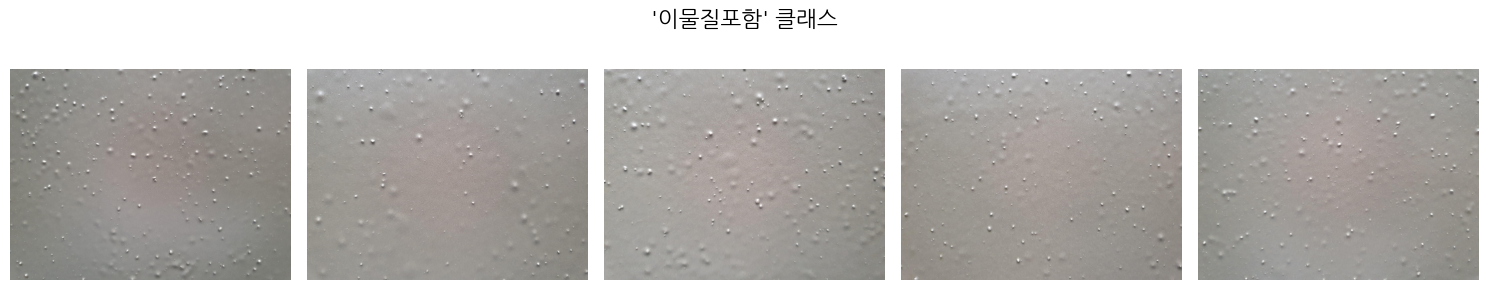



--- [ 양품 ] 이미지 샘플 ---


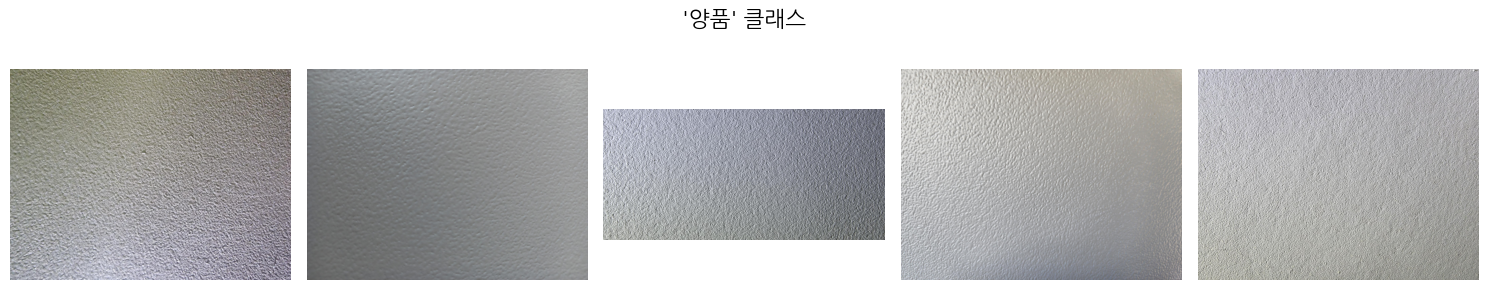



--- [ 양품 ] 이미지 샘플 ---


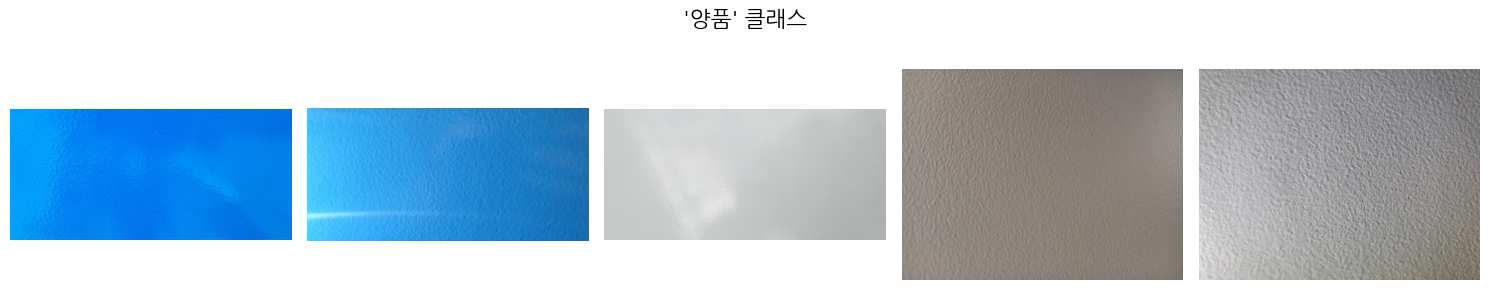

In [9]:
# 각 클래스 폴더를 돌면서 이미지 샘플을 확인.
# folder_to_label 딕셔너리의 키를 사용하여 디렉토리 경로를 구성.
for folder_name, class_name in folder_to_label.items():
    dir_path = CFG["ROOT"] / folder_name
    print(f"--- [ {class_name} ] 이미지 샘플 ---")

    # IMG_EXTS를 사용하여 모든 이미지 파일을 찾기.
    image_paths = []
    # glob으로 한 번에 여러 확장자 찾기
    for ext in IMG_EXTS:
        image_paths.extend(list(dir_path.glob(f"*{ext}")))

    # 보여줄 이미지 개수 (최대 5개)
    num_samples = min(len(image_paths), 5)

    # 이미지가 하나도 없으면 다음 폴더로
    if num_samples == 0:
        print("이미지가 없습니다.")
        continue

    # 무작위로 5개의 이미지를 선택.
    random_images = random.sample(image_paths, num_samples)

    # 1행 num_samples 열의 이미지 플롯(plot)을 생성.
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지를 하나씩 화면에 표시
    for i, img_path in enumerate(random_images):
        # 이미지 열기
        img = Image.open(img_path)

        # 해당 축(subplot)에 이미지 표시
        # 만약 axes가 단일 객체일 경우(이미지가 하나일 때)를 대비하여 조건 처리
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    # 전체 플롯의 제목 설정
    fig.suptitle(f"'{class_name}' 클래스", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # 제목과 겹치지 않도록 레이아웃 조정
    plt.show()
    print("\n")  # 클래스별 구분을 위해 줄바꿈 추가

## 3. 이미지 특성 분석

### 3.1 시각적 특징 평가

육안 검사 결과, 각 범주별 특징이 명확하게 구분되며 이미지 품질이 양호한 것으로 확인되었습니다.
기본 전처리 코드는 128*128의 전처리 코드를 제시하고 있으나 원본이 고해상도 이미지인것을 강제로 다운스케일링 하는 과정에서 모델에게 학습할 정보가 많이 손실된다고 판단하였기 때문에, 조금 더 적절한 전처리 방식을 고민했습니다.

--- [ 테스트 데이터 ] 이미지 샘플 ---


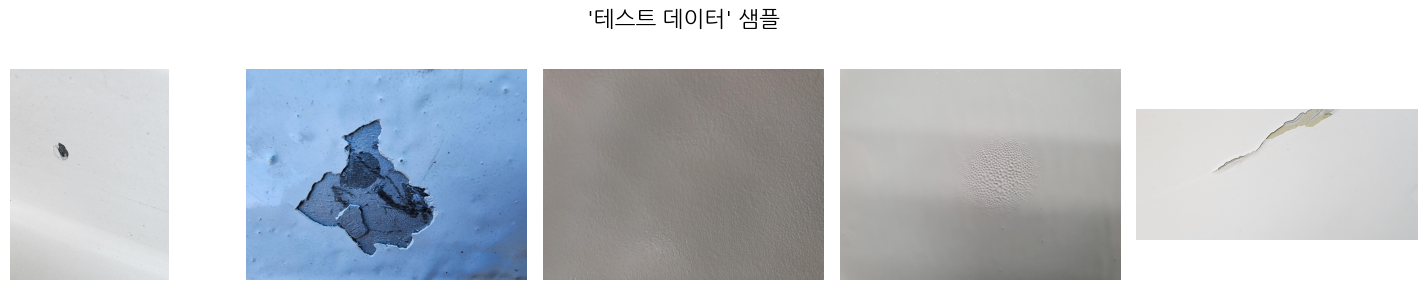

In [10]:
# df_test 데이터프레임에서 이미지 경로 리스트를 가져옴
test_image_paths = df_test['path'].tolist()

print(f"--- [ 테스트 데이터 ] 이미지 샘플 ---")

# 보여줄 이미지 개수 (최대 5개)
num_samples = min(len(test_image_paths), 5)

if num_samples == 0:
    print(" -> 테스트 데이터에 이미지가 없습니다.")
else:
    # 무작위로 이미지 선택
    random_images = random.sample(test_image_paths, num_samples)

    # 이미지 플롯 생성
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

    # 샘플 이미지 표시
    for i, img_path in enumerate(random_images):
        img = Image.open(img_path)
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.axis("off")

    fig.suptitle("'테스트 데이터' 샘플", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### 3.2 이미지 처리 최적화 방안

#### 전처리 전략
이미지 크기와 채널 정보를 분석하여 최적의 전처리 전략을 수립하겠습니다. 우선 모든 이미지의 **width, height, mode**를 추출하여 통계를 확인해보겠습니다.

In [11]:
def get_image_properties(path):
    """이미지 경로를 받아 너비, 높이, 모드를 반환하는 함수"""
    try:
        with Image.open(path) as img:
            return img.width, img.height, img.mode
    except Exception as e:
        print(f"오류 발생: {path}, {e}")
        return None, None, None


# progress_apply를 사용하여 각 이미지의 속성을 계산하고 새 컬럼에 저장
tqdm.pandas() # 진행 상태 확인
df[["width", "height", "mode"]] = df["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n--- [훈련 데이터] 이미지 크기 통계 ---")
display(df[["width", "height"]].describe())

print("\n--- [훈련 데이터] 이미지 모드(채널) 분포 ---")
display(df["mode"].value_counts())

# progress_apply를 사용하여 테스트 이미지의 속성을 계산
df_test[["width", "height", "mode"]] = df_test["path"].progress_apply(
    lambda path: pd.Series(get_image_properties(path))
)

print("\n--- [테스트 데이터] 이미지 크기 통계 ---")
display(df_test[["width", "height"]].describe())

print("\n--- [테스트 데이터] 이미지 모드(채널) 분포 ---")
display(df_test["mode"].value_counts())


  0%|          | 0/1200 [00:00<?, ?it/s]


--- [훈련 데이터] 이미지 크기 통계 ---


width       height
count  1200.00000  1200.000000
mean   2699.88750  2212.416667
std     302.63918   372.842298
min    1272.00000  1272.000000
25%    2828.00000  2138.000000
50%    2851.00000  2138.000000
75%    2851.00000  2138.000000
max    2851.00000  2851.000000


--- [훈련 데이터] 이미지 모드(채널) 분포 ---


mode
RGB    1200
Name: count, dtype: int64

  0%|          | 0/1000 [00:00<?, ?it/s]


--- [테스트 데이터] 이미지 크기 통계 ---


width       height
count  1000.000000  1000.000000
mean   2621.823000  2282.643000
std     352.284334   423.084999
min    1272.000000  1272.000000
25%    2138.000000  2138.000000
50%    2851.000000  2138.000000
75%    2851.000000  2828.000000
max    2851.000000  2986.000000


--- [테스트 데이터] 이미지 모드(채널) 분포 ---


mode
RGB    1000
Name: count, dtype: int64

분석 결과를 보면 모든 이미지가 **RGB 3채널**이고, **평균 2700x2200**의 고해상도를 가지고 있습니다. 따라서 저희는 다음과 같은 전처리 전략을 수립했습니다:

1. **리사이징**: 계산 효율성을 위해 224x224로 조정
2. **정규화**: ImageNet 사전학습 가중치 활용을 위한 표준 정규화
3. **증강**: 제한된 데이터셋 크기를 보완하기 위한 적극적 증강

<a id="sec-3"></a>
## 3. 데이터 전처리 및 증강

## Preprocessing

### 데이터 분할 전략
저희는 전체 데이터를 학습에 사용하는 전략을 선택했습니다. 이는 **제한된 데이터셋 크기(1,200개)** 를 최대한 활용하기 위함이며, 대신 **TTA(Test Time Augmentation)** 를 통해 검증을 대체하고자 했습니다.


In [12]:
# 특성(X)과 라벨(y) 정의
X_train = df["path"]
y_train = df["label"]

print(f"훈련 데이터 샘플 수: {len(X_train)}")
print("\n훈련 데이터 라벨 분포:")
print(y_train.value_counts())

훈련 데이터 샘플 수: 1200

훈련 데이터 라벨 분포:
label
양품       400
스크래치     200
부풀음      200
도막떨어짐    200
이물질포함    200
Name: count, dtype: int64


### 데이터 증강 파이프라인 구축
피처 엔지니어링 및 전처리를 시작하기 전에 우선 어떤 증강 기법이 적합한지 판단해야 합니다. 선박 도장 결함의 특성상 **방향에 무관한 결함**이므로, 다양한 기하학적 변환을 적용할 수 있을 것 같습니다. 어떤 변환을 사용하였는지는 코드에 주석으로 적어두겠습니다.


In [13]:
# --------------------------------------------------------------------------
# 1. 모든 클래스에 적용할 통합 기본 파이프라인
# --------------------------------------------------------------------------
train_transform = A.Compose(
    [
        # 이미지 크기를 224x224로 조정
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        # 50% 확률로 좌우 반전을 적용
        A.HorizontalFlip(p=0.5),
        # 50% 확률로 상하 반전을 적용. 선박 도장 결함들은 방향에 무관
        A.VerticalFlip(p=0.5),
        # 50% 확률로 90,180,270도 회전을 적용
        A.RandomRotate90(p=0.5),
        # 기하학적 변형 추가
        A.ShiftScaleRotate(p=0.5, shift_limit=0.1, scale_limit=0.1, rotate_limit=30),
        # 밝기, 대비, 색상 변형 추가
        A.RandomBrightnessContrast(p=0.7, brightness_limit=0.2, contrast_limit=0.2),
        A.ColorJitter(p=0.5),
        # ImageNet 평균/표준편차로 정규화를 수행.
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        # 이미지를 PyTorch 텐서로 변환.
        ToTensorV2(),
    ]
)


# 검증(Validation) 데이터용 파이프라인은 그대로 유지.
val_transform = A.Compose(
    [
        A.Resize(CFG["IMG_SIZE"], CFG["IMG_SIZE"]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [14]:
# --------------------------------------------------------------------------
# 2. 범용 Augmentation을 적용하는 표준 Custom Dataset
# --------------------------------------------------------------------------
class ShipDefectDataset(Dataset):
    """
    데이터셋 초기화
    
    Args:
        image_paths (list): 이미지 파일 경로 리스트
        labels (list): 각 이미지에 해당하는 라벨 리스트
        class_to_idx (dict): 클래스명을 인덱스로 매핑하는 딕셔너리
        transform: 이미지 변환 함수
    """
    def __init__(self, image_paths, labels, class_to_idx, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        인덱스에 해당하는 이미지와 라벨을 반환합니다
        
        Args:
            idx (int): 가져올 이미지의 인덱스
            
        Returns:
            tuple: (이미지, 라벨 인덱스)
        """
        # 이미지 경로와 라벨(클래스 이름) 가져오기
        image_path = self.image_paths[idx]
        # 라벨이 None인 경우(예: 테스트 데이터셋)를 처리
        class_name = self.labels[idx] if self.labels is not None else None

        # 이미지 불러오기 (OpenCV는 BGR 순서)
        image = cv2.imread(str(image_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 전달받은 transform이 있으면 적용
        if self.transform:
            augmented_image = self.transform(image=image)["image"]
        else:
            # transform이 없는 경우, 원본 이미지를 반환 (또는 기본 transform 적용)
            augmented_image = image

        # 라벨이 None이 아닐 경우에만 클래스 이름을 정수 인덱스로 변환
        # 라벨이 없는 경우를 나타내기 위해 -1을 사용
        label_idx = self.class_to_idx[class_name] if class_name is not None else -1 # Use -1 or some indicator for no label


        return augmented_image, torch.tensor(label_idx, dtype=torch.long)

In [15]:
# 라벨을 정수 인덱스로 매핑하는 딕셔너리 생성
# 고유한 라벨 목록을 얻고 이를 기반으로 인덱스를 할당
unique_labels = sorted(df["label"].unique())
class_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
print(f"클래스-인덱스 매핑: {class_to_idx}")

클래스-인덱스 매핑: {'도막떨어짐': 0, '부풀음': 1, '스크래치': 2, '양품': 3, '이물질포함': 4}


### 커스텀 데이터셋 구현
PyTorch의 Dataset 클래스를 상속받아 구현한 **ShipDefectDataset**은 이미지 로딩과 증강을 효율적으로 처리합니다. 특히 테스트 데이터셋에도 동일한 구조를 사용할 수 있도록 **유연하게 설계**했습니다.


In [16]:
# 학습용 데이터셋 생성: 통합 기본 파이프라인(train_transform) 적용
train_dataset = ShipDefectDataset(
    image_paths=X_train.tolist(),
    labels=y_train.tolist(),
    class_to_idx=class_to_idx,
    transform=train_transform,
)

# # 검증용 데이터셋 생성: 증강 없는 파이프라인(val_transform) 적용
# val_dataset = ShipDefectDataset(
#     image_paths=X_val.tolist(),
#     labels=y_val.tolist(),
#     class_to_idx=class_to_idx,
#     transform=val_transform,
# )

In [17]:
# 데이터로드 시 병렬 처리를 위한 시드 설정
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(CFG["SEED"])

In [18]:
# 데이터로더 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=True,
    num_workers=2,                      
    pin_memory=True,                  # num_workers > 0 일 때 데이터 로딩 속도를 높여 모델 훈련 효율을 개선함
    worker_init_fn=seed_worker,   # 각 워커가 독립적이면서도 예측 가능한 무작위성을 갖게 되어, 데이터 증강 결과가 실행마다 동일하게 재현되도록 함
    generator=g,                            # 매 실행마다 똑같은 데이터 로딩 순서를 보장
)

# val_loader = DataLoader(
#     val_dataset,
#     batch_size=CFG["BATCH_SIZE"],
#     shuffle=False,
#     num_workers=2,
#     pin_memory=True,
#     worker_init_fn=seed_worker,
#     generator=g,
# )

### 증강 결과 시각화
구현한 증강 파이프라인이 제대로 작동하는지 확인하기 위해 시각화를 진행하겠습니다. 원본 이미지와 증강된 이미지를 비교하여 **증강의 다양성**과 **품질**을 확인할 수 있습니다.

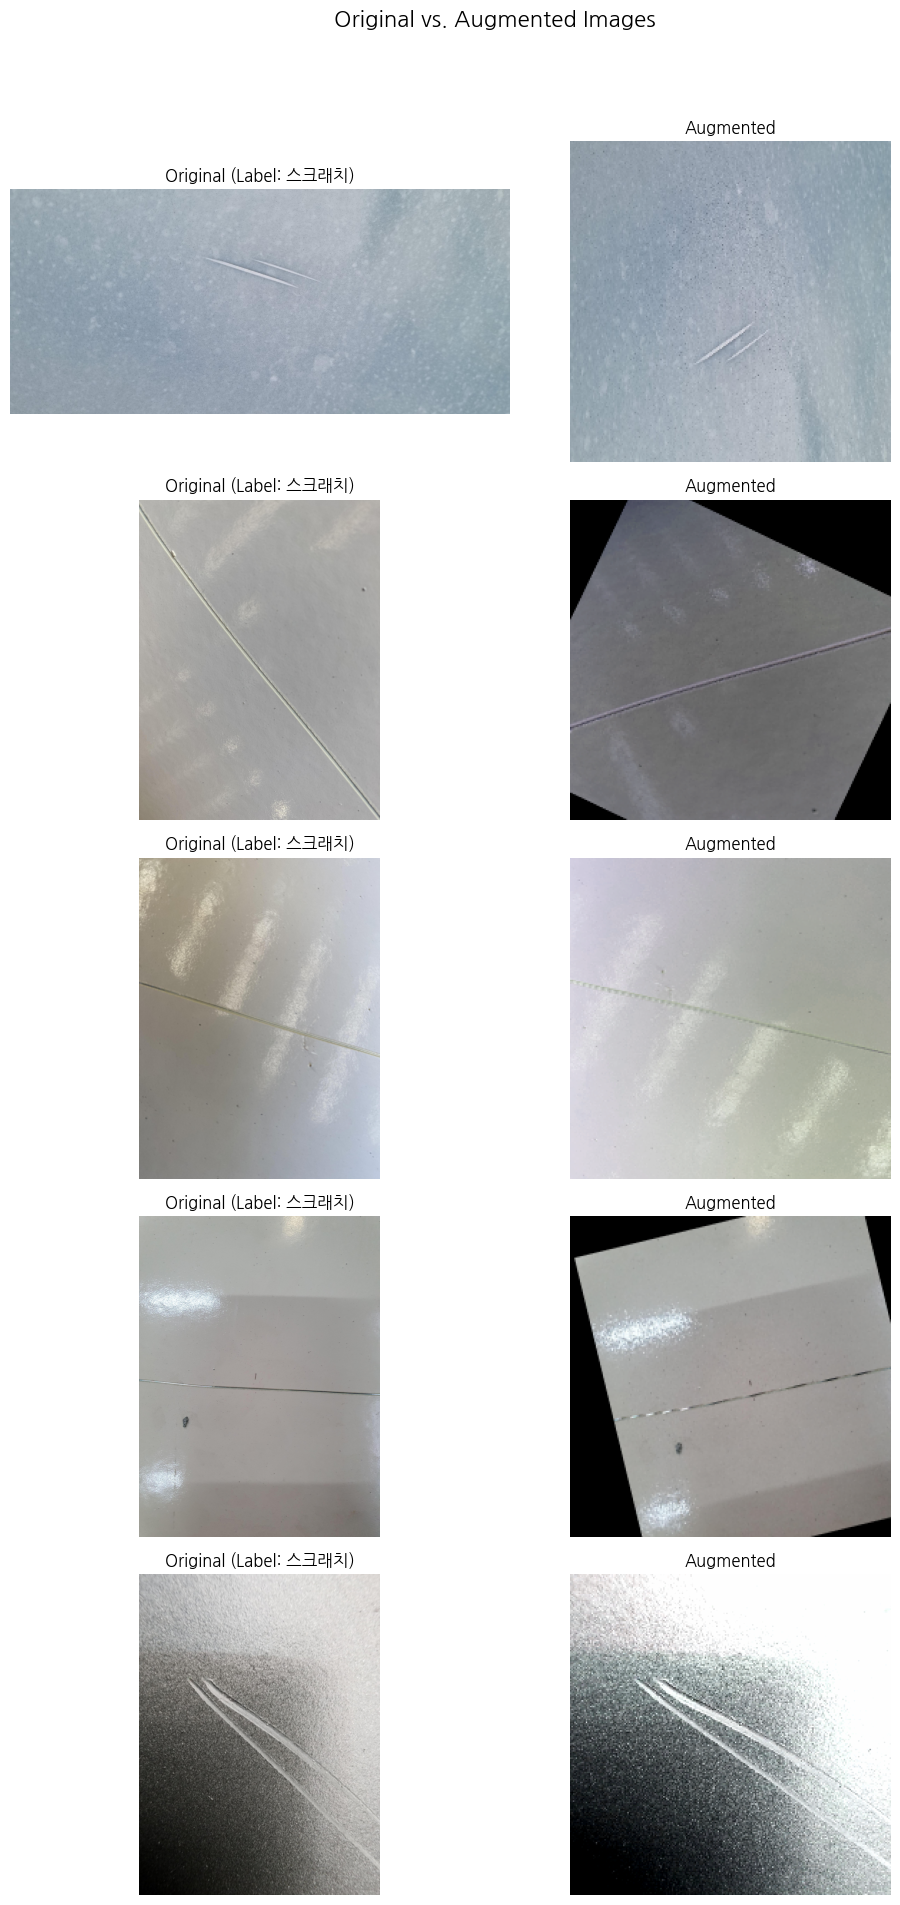

In [19]:
def visualize_augmentation(dataset, idx=0, samples=5):
    """
    데이터 증강 결과를 시각화합니다
    
    Args:
        dataset: 증강이 적용된 데이터셋
        idx (int): 시각화할 이미지의 인덱스
        samples (int): 보여줄 증강 샘플 수
    """
    
    fig, axes = plt.subplots(samples, 2, figsize=(10, 4 * samples))
    fig.suptitle("Original vs. Augmented Images", fontsize=16)

    for i in range(samples):
        # 원본 이미지를 로드하기 위해 dataset.image_paths 사용
        original_img_path = dataset.image_paths[idx + i]
        original_img = cv2.imread(original_img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

        # 증강된 이미지와 라벨 가져오기 (Dataset의 __getitem__ 사용)
        augmented_img, label_idx = dataset[idx + i]
        label_name = list(dataset.class_to_idx.keys())[
            list(dataset.class_to_idx.values()).index(label_idx)
        ]

        # Matplotlib으로 시각화하기 위해 역정규화(denormalization)
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        # 텐서 차원 변경 (C, H, W) -> (H, W, C)
        augmented_img_np = augmented_img.permute(1, 2, 0).numpy()
        augmented_img_np = std * augmented_img_np + mean
        augmented_img_np = np.clip(
            augmented_img_np, 0, 1
        )  # 픽셀 값을 [0, 1] 범위로 클립

        # 원본 이미지 표시
        axes[i, 0].imshow(original_img)
        axes[i, 0].set_title(f"Original (Label: {label_name})")
        axes[i, 0].axis("off")

        # 증강된 이미지 표시
        axes[i, 1].imshow(augmented_img_np)
        axes[i, 1].set_title("Augmented")
        axes[i, 1].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# --- 시각화 실행 ---
visualize_augmentation(train_dataset, idx=0, samples=5)

<a id="sec-4"></a>
## 4. 모델링 및 학습

## 모델 학습

### 4.1 모델 아키텍처 선택

저희가 선택한 모델들은 각각 다른 장점을 가지고 있습니다. **다양한 아키텍처**를 실험하는 것이 Arena 방식 개발의 핵심이므로, CNN 기반과 Transformer 기반 모델을 모두 포함시켰습니다.

| 모델명 (timm) | 아키텍처 | 파라미터 수 | 사전 훈련 데이터셋 | 특징 |
| :--- | :--- | :--- | :--- | :--- |
| `regnety_120.sw_in12k_ft_in1k` | **RegNetY** (CNN) | 약 120M | ImageNet-12k | 설계 공간(Design Space) 개념, 효율적인 구조, Squeeze-and-Excitation |
| `tiny_vit_21m_384.dist_in22k_ft_in1k` | **Tiny-ViT** (Transformer) | 약 21M | ImageNet-22k | Vision Transformer, 지식 증류(Distillation), 경량화 |
| `tf_efficientnetv2_s.in21k_ft_in1k` | **EfficientNetV2-S** (CNN) | 약 21M | ImageNet-21k | Fused-MBConv, 점진적 학습(Progressive Learning), 훈련 속도 개선 |

### 4.2 학습 전략

학습 과정에서 **재현성**을 보장하고 **안정적인 수렴**을 위해 다음과 같은 전략을 수립했습니다:

1. **옵티마이저**: AdamW with weight decay (과적합 방지)
2. **스케줄러**: ReduceLROnPlateau (성능 정체 시 학습률 감소)
3. **Gradient Clipping**: 그래디언트 폭발 방지

### 4.3 마지막 성능 향상 전략
1. 사전에 Train/Validation(8:2) history 기록을 참고하여 모델의 성능이 수렴하는 epochs 파악
- 15 epoch에서부터 train, validation 성능이 수렴하는 것을 확인함
2. Train validation split 없이 모든 데이터를 학습
- 모든 데이터를 사용하면 Iteration이 이전보다 20% 이상 증가함: 수렴 속도가 빨리지는 것을 확인
- Train Set 과적합을 고려하여 15미만인 10 epochs 선택
3. 80% 데이터로 학습했을 때보다 Public Score가 개선되었는지 확인
- Test Set 과적합을 고려하여 성능이 80% 학습 모델보다 개선되지 않으면 과감하게 폐기(많은 실험 X)
4. Train/Validation(8:2) history 전 과정에 대한 세부사항은 아래 github에서 확인 가능합니다.
- https://github.com/DoHyeon6210/Project-Repo/blob/main/Image_com/history.ipynb
5. Train/Validation(8:2) history 기록 이미지
- regnety_120
![설명 텍스트](사진1.JPG)

- tiny_vit_21m_384
![설명 텍스트](사진2.JPG)

- tf_efficientnetv2_s
![설명 텍스트](사진3.JPG)

In [20]:
# 모델 훈련 함수 정의
def train(model, optimizer, scheduler, train_loader, device, epochs):
    """
    모델 학습을 수행하는 함수

    Args:
        model: 학습할 모델
        optimizer: 최적화 알고리즘
        scheduler: 학습률 스케줄러
        train_loader: 학습 데이터 로더
        device: 학습 디바이스 (CPU/GPU)
        
    Returns:
        dict: 학습 결과 정보
    """
    
    model.to(device)
    # 손실 함수 정의
    criterion = nn.CrossEntropyLoss().to(device)

    # 최고 성능 저장을 위한 변수 초기화
    best_macro_f1 = 0.0

    # 훈련 메트릭스 기록을 위한 history 딕셔너리 초기화
    history = {
        'train_loss': [],
        'train_accuracy': [],
        'train_macro_f1': []
    }
    
    # 체크포인트 저장 경로 설정 및 디렉토리 생성
    model_class_name = model.__class__.__name__
    checkpoint_dir = Path(f"./checkpoints/{model_class_name}")
    checkpoint_interval = 10 # 10 에폭마다 체크포인트 저장
    checkpoint_dir.mkdir(exist_ok=True, parents=True)

    print("======== Training Start ========")
    # 설정된 에폭 수만큼 훈련 반복
    for epoch in range(epochs):

        # --- 1. 훈련 단계 ---
        model.train() # 모델을 훈련 모드로 설정
        train_loss = 0.0 # 에폭별 훈련 손실 초기화
        all_train_preds = [] # history 기록을 위한 저장 리스트
        all_train_labels = []
        
        # 훈련 데이터 로더를 순회하며 배치 학습
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Training"):
            # 데이터를 지정된 디바이스로 이동
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad() # 이전 스텝의 기울기 초기화
            outputs = model(images) # 모델에 이미지 입력하여 예측 (순전파)
            loss = criterion(outputs, labels) # 예측값과 실제 라벨 비교하여 손실 계산
            loss.backward() # 역전파: 손실에 대한 기울기 계산
            optimizer.step() # 옵티마이저 스텝: 모델 파라미터 업데이트

            train_loss += loss.item() # 배치 손실을 누적
            
            # history 기록을 위한 예측값, 실제값 저장
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy()) 
            all_train_labels.extend(labels.cpu().numpy())
            
        avg_train_loss = train_loss / len(train_loader) # 평균 훈련 손실 계산
        train_accuracy = (np.array(all_train_preds) == np.array(all_train_labels)).mean() # 훈련 정확도 계산
        train_macro_f1 = f1_score(all_train_labels, all_train_preds, average='macro') # F1 스코어  계산
        
        # train history 저장
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)
        history['train_macro_f1'].append(train_macro_f1)
        
        # 스케줄러가 정의되어 있으면 학습률 조정
        if scheduler is not None:
            scheduler.step(avg_train_loss) # 훈련 손실을 기준으로 스케줄러 스텝

        # --- 2. 결과 출력 ---
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Macro F1: {train_macro_f1:.4f}")
              
        # --- 3. 주기적 체크포인트 저장  ---
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch+1}.pth"
            print(f"  >> Saving checkpoint at epoch {epoch+1} to {checkpoint_path}...")
            # 현재 에폭, 모델 상태, 옵티마이저 상태 등을 체크포인트 파일로 저장
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'best_macro_f1': best_macro_f1, # 체크포인트 저장 시점의 최고 F1 스코어 (선택 사항)
                'history': history,
            }, checkpoint_path)

    print(f"======== Training Finished ========")
    # 훈련 완료 후, 최고 성능 모델과 오분류 샘플 리스트 반환
    return model, history

In [21]:
# Train history 기록을 시각화하는 코드
def visualize_history(history):
    """
    훈련 메트릭스 기록을 시각화합니다.
    손실, 정확도, F1 스코어를 각각 별도의 그래프로 표시합니다.

    Args:
        history (dict): 'train_loss', 'train_accuracy', 'train_macro_f1'
                        리스트를 포함하는 딕셔너리.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    # 1. 손실(Loss) 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_loss'], 'o-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. 정확도(Accuracy) 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_accuracy'], 'o-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3. 매크로 F1 스코어 시각화
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, history['train_macro_f1'], 'o-', label='Training Macro F1')
    plt.title('Training Macro F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Macro F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### 추론 과정에서 메모리 문제 발생 시 커널 초기화 이후 이 마크다운 위로 재실행

이제 모델을 학습시키고 결과를 가중치로 저장해 추론에 사용할 준비를 합니다.

In [21]:
# model : regnet 
model = timm.create_model(
    "hf_hub:timm/regnety_120.sw_in12k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8)

trained_model, history = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    device=CFG['DEVICE'],
    epochs=CFG["EPOCHS"]
)

# 훈련된 모델의 가중치를 파일로 저장
torch.save(trained_model.state_dict(), f'./all_data_regnety_120_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth')

======== Training Start ========


Epoch 1/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10
  Train Loss: 0.4556, Train Accuracy: 0.8433, Train Macro F1: 0.8336


Epoch 2/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10
  Train Loss: 0.1678, Train Accuracy: 0.9517, Train Macro F1: 0.9471


Epoch 3/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10
  Train Loss: 0.1233, Train Accuracy: 0.9608, Train Macro F1: 0.9582


Epoch 4/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10
  Train Loss: 0.0782, Train Accuracy: 0.9758, Train Macro F1: 0.9750


Epoch 5/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10
  Train Loss: 0.0589, Train Accuracy: 0.9792, Train Macro F1: 0.9767


Epoch 6/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff258d37c70>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff258d37c70>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

Epoch 6/10
  Train Loss: 0.0518, Train Accuracy: 0.9867, Train Macro F1: 0.9857


Epoch 7/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/10
  Train Loss: 0.0347, Train Accuracy: 0.9900, Train Macro F1: 0.9893


Epoch 8/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/10
  Train Loss: 0.0220, Train Accuracy: 0.9950, Train Macro F1: 0.9948


Epoch 9/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/10
  Train Loss: 0.0197, Train Accuracy: 0.9942, Train Macro F1: 0.9940


Epoch 10/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/10
  Train Loss: 0.0081, Train Accuracy: 0.9983, Train Macro F1: 0.9982
  >> Saving checkpoint at epoch 10 to checkpoints/RegNet/checkpoint_epoch_10.pth...
======== Training Finished ========


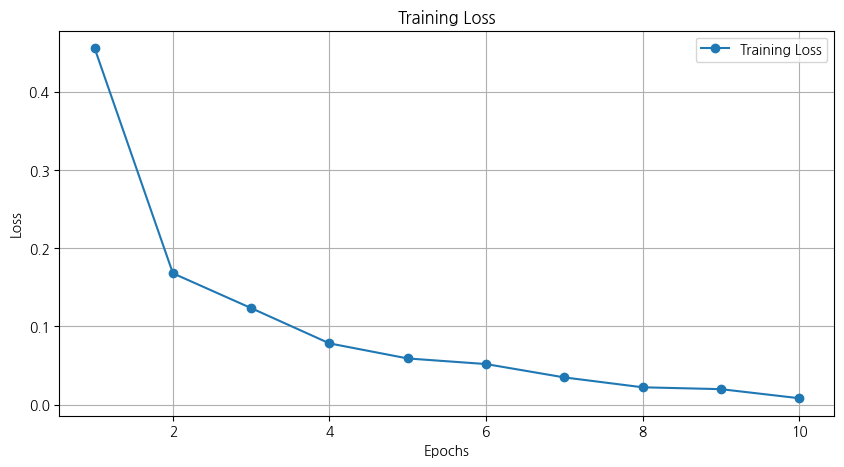

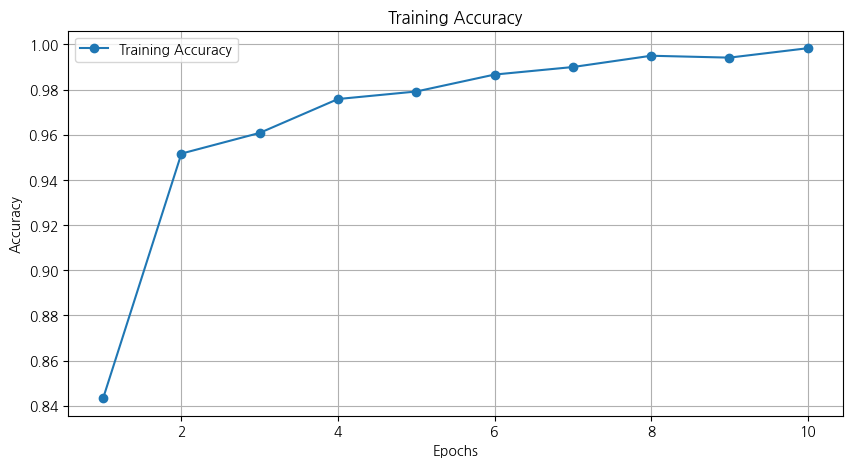

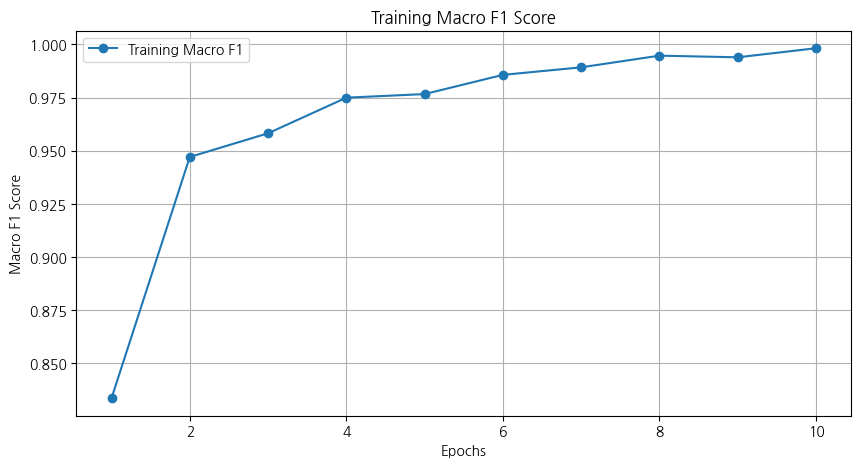

In [22]:
visualize_history(history)

In [23]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [24]:
# model 2: ViT
model = timm.create_model(
    "hf_hub:timm/tiny_vit_21m_384.dist_in22k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)

optimizer = torch.optim.AdamW(params = model.parameters(), 
                              lr = CFG["LEARNING_RATE"], 
                              weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                       mode='max', 
                                                       factor=0.5, 
                                                       patience=2, 
                                                       threshold_mode='abs', 
                                                       min_lr=1e-8)

trained_model2, history2 = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    device=CFG['DEVICE'],
    epochs=CFG["EPOCHS"]
)

torch.save(trained_model2.state_dict(), f'./all_data_tiny_vit384_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth')

======== Training Start ========


Epoch 1/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10
  Train Loss: 1.1622, Train Accuracy: 0.6758, Train Macro F1: 0.6581


Epoch 2/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10
  Train Loss: 0.3368, Train Accuracy: 0.9625, Train Macro F1: 0.9590


Epoch 3/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10
  Train Loss: 0.1674, Train Accuracy: 0.9608, Train Macro F1: 0.9574


Epoch 4/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10
  Train Loss: 0.1014, Train Accuracy: 0.9800, Train Macro F1: 0.9772


Epoch 5/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10
  Train Loss: 0.0688, Train Accuracy: 0.9867, Train Macro F1: 0.9845


Epoch 6/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff258d37c70>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff258d37c70>
Traceback (most recent call last):
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/home/elicer/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1646, in _shutdown_work

Epoch 6/10
  Train Loss: 0.0708, Train Accuracy: 0.9867, Train Macro F1: 0.9850


Epoch 7/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/10
  Train Loss: 0.0594, Train Accuracy: 0.9850, Train Macro F1: 0.9840


Epoch 8/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/10
  Train Loss: 0.0614, Train Accuracy: 0.9892, Train Macro F1: 0.9890


Epoch 9/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/10
  Train Loss: 0.0395, Train Accuracy: 0.9950, Train Macro F1: 0.9945


Epoch 10/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/10
  Train Loss: 0.0391, Train Accuracy: 0.9933, Train Macro F1: 0.9930
  >> Saving checkpoint at epoch 10 to checkpoints/TinyVit/checkpoint_epoch_10.pth...
======== Training Finished ========


In [25]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

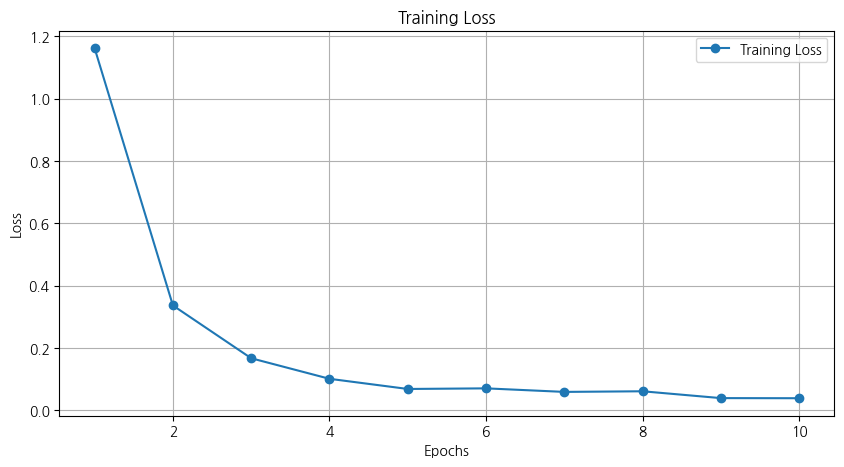

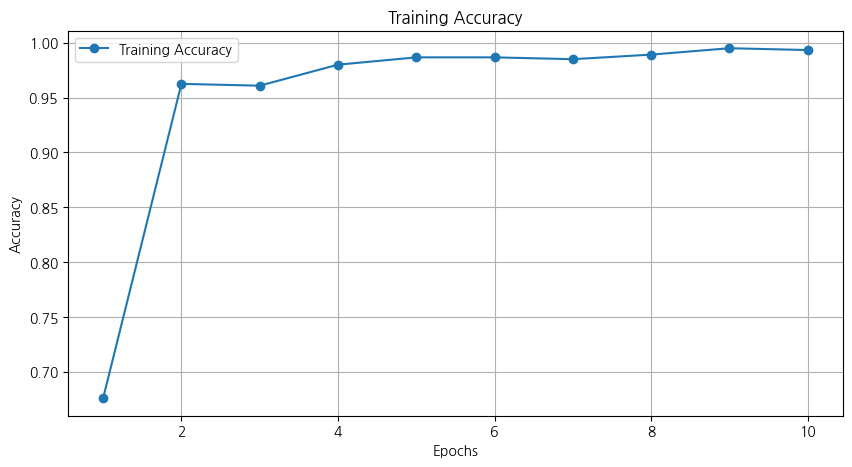

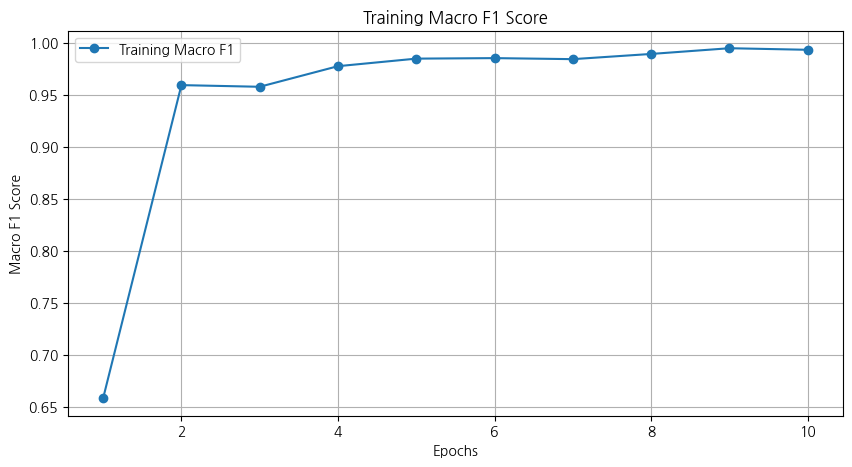

In [26]:
visualize_history(history2)

In [27]:
# model 3: efficientnetv2
model = timm.create_model(
    "hf_hub:timm/tf_efficientnetv2_s.in21k_ft_in1k",
    pretrained=True,
    num_classes=CFG["NUM_CLASSES"],
)
optimizer = torch.optim.AdamW(params = model.parameters(), lr = CFG["LEARNING_RATE"], weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8)

trained_model3, history3 = train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    device=CFG['DEVICE'],
    epochs=CFG["EPOCHS"]
)

torch.save(trained_model3.state_dict(), f'./all_data_effi_s_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth')

======== Training Start ========


Epoch 1/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 1/10
  Train Loss: 1.4333, Train Accuracy: 0.7983, Train Macro F1: 0.7848


Epoch 2/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 2/10
  Train Loss: 0.4130, Train Accuracy: 0.9233, Train Macro F1: 0.9185


Epoch 3/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 3/10
  Train Loss: 0.2236, Train Accuracy: 0.9517, Train Macro F1: 0.9497


Epoch 4/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 4/10
  Train Loss: 0.1936, Train Accuracy: 0.9642, Train Macro F1: 0.9616


Epoch 5/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 5/10
  Train Loss: 0.0966, Train Accuracy: 0.9742, Train Macro F1: 0.9729


Epoch 6/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 6/10
  Train Loss: 0.0979, Train Accuracy: 0.9758, Train Macro F1: 0.9750


Epoch 7/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 7/10
  Train Loss: 0.1396, Train Accuracy: 0.9675, Train Macro F1: 0.9650


Epoch 8/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 8/10
  Train Loss: 0.0887, Train Accuracy: 0.9800, Train Macro F1: 0.9785


Epoch 9/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 9/10
  Train Loss: 0.0579, Train Accuracy: 0.9850, Train Macro F1: 0.9838


Epoch 10/10 Training:   0%|          | 0/75 [00:00<?, ?it/s]

Epoch 10/10
  Train Loss: 0.0983, Train Accuracy: 0.9800, Train Macro F1: 0.9790
  >> Saving checkpoint at epoch 10 to checkpoints/EfficientNet/checkpoint_epoch_10.pth...
======== Training Finished ========


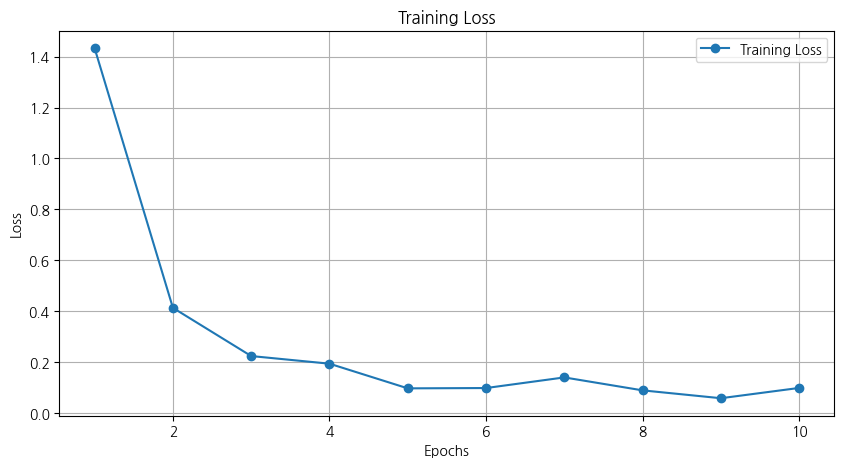

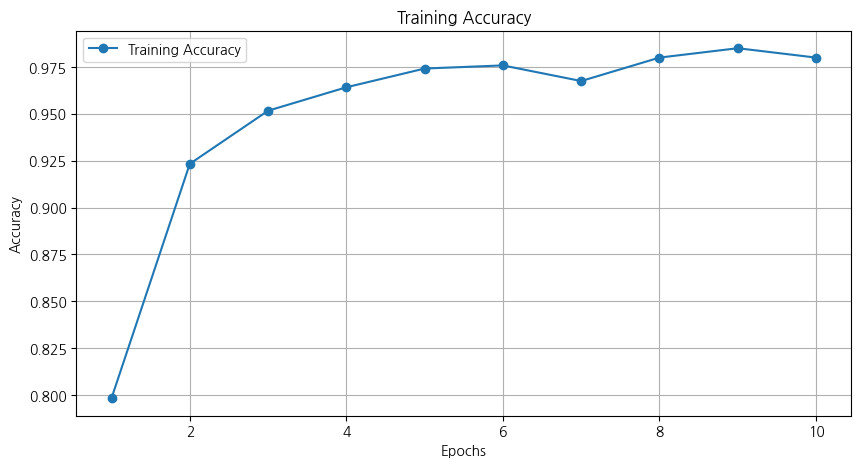

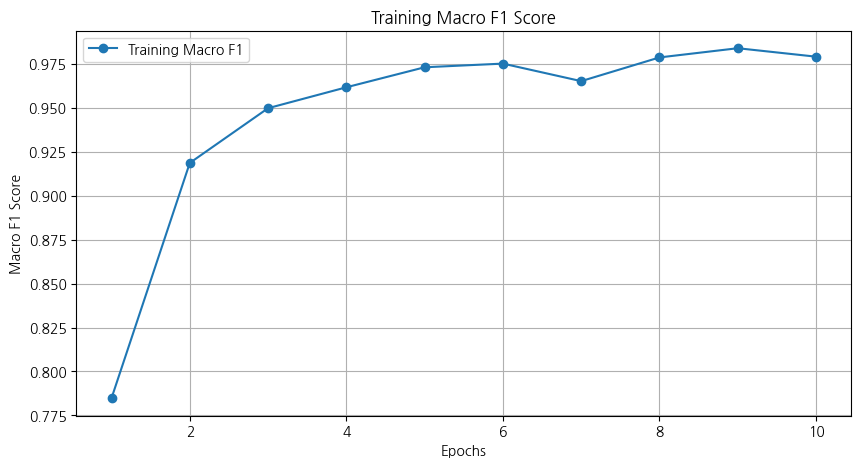

In [28]:
visualize_history(history3)

<a id="sec-5"></a>
## 5. 평가 및 결과

## 모델 평가 및 결과 저장

### Test Time Augmentation (TTA) 전략
추론 시점의 성능을 향상시키기 위해 **두 가지 TTA 기법**을 적용했습니다:

1. **기하학적 TTA**: 7가지 변환 적용 (원본, 반전, 회전 등)
2. **다중 스케일 TTA**: 여러 스케일에서 예측 후 평균

이러한 TTA를 통해 모델의 **예측 불확실성을 감소**시키고 더 **robust한 예측**을 얻을 수 있었습니다.

In [22]:
# 학습 완료된 모델 불러오기
model1 = timm.create_model(
    "hf_hub:timm/tiny_vit_21m_384.dist_in22k_ft_in1k",
    pretrained=False
)
model1.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model1.to(CFG['DEVICE'])
model1.load_state_dict(torch.load(f'./all_data_tiny_vit384_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth', map_location=CFG['DEVICE']))

model2 = timm.create_model(
    "hf_hub:timm/tf_efficientnetv2_s.in21k_ft_in1k",
    pretrained=False
)
model2.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model2.to(CFG['DEVICE'])
model2.load_state_dict(torch.load(f'./all_data_effi_s_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth', map_location=CFG['DEVICE']))

model3 = timm.create_model(
    "hf_hub:timm/regnety_120.sw_in12k_ft_in1k",
    pretrained=False
)
model3.reset_classifier(num_classes=CFG["NUM_CLASSES"])
model3.to(CFG['DEVICE'])
model3.load_state_dict(torch.load(f'./all_data_regnety_120_{CFG["IMG_SIZE"]}_{CFG["EPOCHS"]}_{CFG["NUM_CLASSES"]}.pth', map_location=CFG['DEVICE']))

<All keys matched successfully>

In [23]:
class_names = unique_labels
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

SCALES = [1.0, 1.2]  # 100%, 120% 크기로 테스트

In [24]:
# --- 1. 기하학적 TTA 함수  ---
def apply_geometric_tta(imgs):
    """
    기하학적 테스트 시간 증강(Test Time Augmentation)을 적용합니다
    
    Args:
        imgs: 입력 이미지들
        
    Returns:
        list: 증강된 이미지 리스트
    """

    tta_list = [
        imgs,
        torch.flip(imgs, dims=[3]),  # 좌우 반전
        torch.flip(imgs, dims=[2]),  # 상하 반전
        torch.rot90(imgs, k=1, dims=[2, 3]),
        torch.rot90(imgs, k=2, dims=[2, 3]),
        torch.rot90(imgs, k=3, dims=[2, 3]),
        torch.transpose(imgs, 2, 3),
    ]
    return torch.cat(tta_list, dim=0)

# --- 2. 멀티스케일 TTA를 적용하는 함수 ---
def apply_multiscale_tta(imgs, scales, target_size):
    """
    다중 스케일 TTA 적용합니다
    
    Args:
        imgs: 입력 이미지들
        scales (list): 적용할 스케일 리스트
        target_size (tuple): 목표 이미지 크기
        
    Returns:
        list: 증강된 이미지 리스트
    """
    all_tta_batches = []
    
    for scale in scales:
        # 1. 스케일에 맞춰 이미지 크기 조절
        # antialias=True는 이미지 품질 저하를 막아주는 옵션입니다.
        scaled_imgs = F.resize(imgs, size=[int(target_size * scale), int(target_size * scale)], antialias=True)
        
        # 2. 모델 입력 크기에 맞게 중앙을 잘라냄 (Center Crop)
        cropped_imgs = F.center_crop(scaled_imgs, output_size=[target_size, target_size])
        
        # 3. 스케일이 적용된 이미지에 7가지 기하학적 TTA 적용
        geometric_tta_batch = apply_geometric_tta(cropped_imgs)
        all_tta_batches.append(geometric_tta_batch)
        
    return torch.cat(all_tta_batches, dim=0)

# --- 3. 최종 TTA 추론 및 확률 계산 함수 ---
def get_tta_probs(model, loader, device, scales, target_size):
    """
    다중 스케일 테스트 시간 증강을 적용합니다
    
    Args:
        imgs: 입력 이미지들
        scales (list): 적용할 스케일 리스트
        target_size (tuple): 목표 이미지 크기
        
    Returns:
        list: 증강된 이미지 리스트
    """
    model.eval()
    all_probs = []
    
    # 기하학적 TTA 개수는 7개로 고정
    geometric_tta_count = 7
    # 전체 TTA 개수는 스케일 수 * 기하학적 TTA 수
    total_tta_count = len(scales) * geometric_tta_count

    with torch.no_grad():
        for imgs, _ in tqdm(loader, desc=f"Inference with {len(scales)} Scales TTA"):
            imgs = imgs.to(device)
            
            original_batch_size = imgs.shape[0]

            # 1. 멀티스케일 TTA가 적용된 모든 이미지 배치를 한 번에 생성
            # shape: (배치크기 * 스케일 수 * 7, C, H, W)
            imgs_tta = apply_multiscale_tta(imgs, scales=scales, target_size=target_size)
            
            # 2. 모든 TTA 이미지를 모델에 전달
            preds = model(imgs_tta)
            
            # 3. 예측 결과를 TTA별로 분리하고 평균 계산
            # (배치크기 * total_tta_count, 클래스 수) -> (total_tta_count, 배치크기, 클래스 수)
            num_classes = preds.shape[1]
            preds_view = preds.view(total_tta_count, original_batch_size, num_classes)
            
            # 모든 TTA 결과의 평균 logits 계산
            avg_preds = preds_view.mean(0) # shape: (배치크기, 클래스 수)
            
            # 확률 값으로 변환 (Softmax)
            probs = avg_preds.softmax(1)
            all_probs.append(probs.cpu().numpy())
            
    final_probs = np.concatenate(all_probs, axis=0)
    return final_probs

In [25]:
# 테스트 데이터셋 준비
TEST_ROOT = CFG["ROOT"] / "제출용 데이터"
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp"}

# 테스트 이미지 경로 수집
test_image_paths = []
for p in TEST_ROOT.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        test_image_paths.append(str(p))

#  파일명을 기준으로 경로를 정렬하여 일관된 순서 유지
test_image_paths = sorted(test_image_paths, key=lambda x: Path(x).name)

# 테스트 데이터셋을 위한 임시 라벨 리스트 생성 (추론 시에는 실제 라벨이 없음)
# 추론에는 이미지 경로만 필요함
test_labels_dummy = [None] * len(test_image_paths)

# 검증용 transform을 사용하여 테스트 데이터셋 생성
test_dataset = ShipDefectDataset(
    image_paths=test_image_paths,
    labels=test_labels_dummy, # 더미 라벨
    class_to_idx=class_to_idx, 
    transform=val_transform, # validation transform 사용
)


# 테스트 데이터로더 생성
test_loader = DataLoader(
    test_dataset,
    batch_size=CFG["BATCH_SIZE"],
    shuffle=False, 
)

print(f"✅ {len(test_image_paths)}개의 이미지로 테스트 데이터셋 준비 완료.")

✅ 1000개의 이미지로 테스트 데이터셋 준비 완료.


## 메모리 한계로 인한 엔비디아 오류 발생 시

엘리스 클라우드의 환경 특성상 메모리 제한으로 인해 CUDA 메모리 오류가 발생할 수 있습니다. 저희도 이 문제를 완벽하게 방지하기 위해 여러가지 방법을 시도해봤지만 결론적으로 NVML(엔비디아 관리 라이브러리)와 결부된 저수준 이슈이기때문에 완벽한 해결이 불가능하다고 판단하여 우선은 실행 도중 오류가 발생했을때의 대처법을 안내하는 방식으로 노트북 이용을 제안합니다. 이를테면 다음과 같은 오류 메시지를 볼 수 있는데요,

```bash
:RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1016, please report a bug to PyTorch.
```

다음과 같은 절차를 따르는 것으로 해결이 가능합니다.
1. Kernel Restart 한 뒤 모델 학습만 생략하고 나머지 셀을 실행한다.(저장된 가중치 파일을 사용하기 위함입니다.) 모델 학습 셀을 Ctrl + /로 주석처리 하는 방법으로 진행 가능합니다.
2. 저장된 .pth로부터 모델 가중치를 가져와 TTA, 추론 코드가 정상 작동한다.

In [1]:
!nvidia-smi

Wed Aug 20 01:04:18 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.06             Driver Version: 535.183.06   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:17:00.0 Off |                   On |
| N/A   35C    P0              72W / 300W |                  N/A |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

### 앙상블 전략

세 모델의 예측 확률을 **가중 평균**하여 최종 예측을 수행했습니다. 이를 통해 단일 모델의 약점을 보완하고 더 안정적인 성능을 달성할 수 있었습니다.

#### RuntimeError: NVML_SUCCESS == r INTERNAL ASSERT FAILED 발생 시 주의사항
- 커널 restart 이후 모델 학습 코드와 아래 # 1 셀은 생략하고 나머지 셀만 실행

In [70]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [71]:
# 1
# model1, model2 먼저 TTA 예측 수행
probs1 = get_tta_probs(model1, test_loader, CFG['DEVICE'],scales=SCALES,target_size=CFG['IMG_SIZE'])
probs2 = get_tta_probs(model2, test_loader, CFG['DEVICE'],scales=SCALES,target_size=CFG['IMG_SIZE'])

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

In [26]:
# 메모리 문제를 대비하여 넘파이 배열인 probs1, probs2 예측결과를 저장
np.save(f'probs1.npy', probs1)
np.save(f'probs2.npy', probs2)

# 추론 시 저장한 probs1, probs2 예측결과 불러오기
probs1 = np.load('probs1.npy')
probs2 = np.load('probs2.npy')

In [27]:
# OOM 방지를 위해 캐시된(cached) 메모리를 해제
torch.cuda.empty_cache()

In [30]:
# model3 메모리로 인한 런타임 에러 발생 시 대처
try:
    probs3 = get_tta_probs(model3, test_loader, CFG['DEVICE'], scales=SCALES, target_size=CFG['IMG_SIZE'])
except RuntimeError as e:
    # 에러 메시지에 "INTERNAL ASSERT FAILED"가 포함된 경우
    if "INTERNAL ASSERT FAILED" in str(e):
        print(f"Error occurred with model3: {e}")
        print("Skipping model3 and continuing.")
        probs3 = None  # 오류가 발생했으므로 probs3를 None으로 설정
    else:
        # 다른 종류의 RuntimeError는 다시 발생시킴
        raise e

Inference with 2 Scales TTA:   0%|          | 0/63 [00:00<?, ?it/s]

In [31]:
# 확률값을 다 더하고 최대값 인덱스 구하기
weighted_probs = probs1 + probs2 + probs3

final_preds = np.argmax(weighted_probs, axis=1)

In [32]:
# 예측 결과 처리
# 예측된 인덱스를 다시 클래스 이름으로 변환
idx_to_class = {idx: label for label, idx in class_to_idx.items()}
predicted_class_names = [idx_to_class[pred] for pred in final_preds]

# '양품선'과 '양품외'를 '양품'으로 통합
processed_labels = ["양품" if label in ["양품선", "양품외"] else label for label in predicted_class_names]

print("✅ 예측 결과 처리 완료.")

✅ 예측 결과 처리 완료.


In [33]:
# 제출 파일 생성
# pandas DataFrame 생성
test_filenames = []
test_filenames = [Path(p).name for p in test_image_paths]
df_submit = pd.DataFrame({"label": processed_labels}, index=test_filenames)

# 일관성을 위해 파일명으로 인덱스 정렬
df_submit = df_submit.sort_index()

# 제출 파일 저장
submission_path = "./submission.csv"
df_submit.to_csv(submission_path, encoding="utf-8")

print(f"✅ 제출 파일이 {submission_path}에 저장되었습니다.")
display(df_submit.head())

✅ 제출 파일이 ./submission.csv에 저장되었습니다.


label
00001.jpg  도막떨어짐
00002.jpg  도막떨어짐
00003.jpg   스크래치
00004.jpg   스크래치
00005.jpg     양품

## 예측값 분포 확인

softmax를 적용해 출력값을 확률분포화하고 히스토그램을 사용해 시각화하겠습니다.

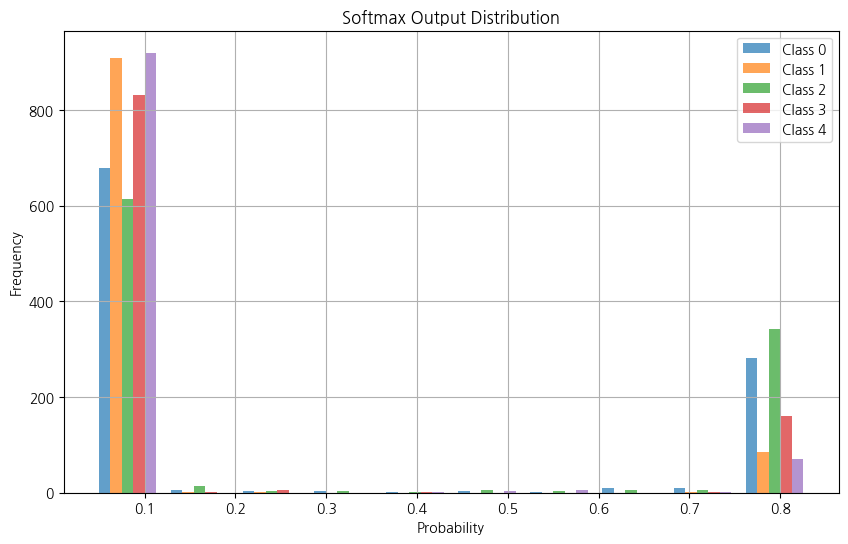

In [34]:
# Softmax 적용을 위해 NumPy array를 PyTorch tensor로 변경
weighted_probs_tensor = torch.from_numpy(weighted_probs)

# Softmax 적용
softmax_output = nn.functional.softmax(weighted_probs_tensor, dim=1)

# 시각화를 위해 PyTorch tensor를 NumPy array로 변경
softmax_np = softmax_output.numpy()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist(softmax_np, bins=10, label=[f'Class {i}' for i in range(softmax_np.shape[1])], alpha=0.7)
plt.title('Softmax Output Distribution')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

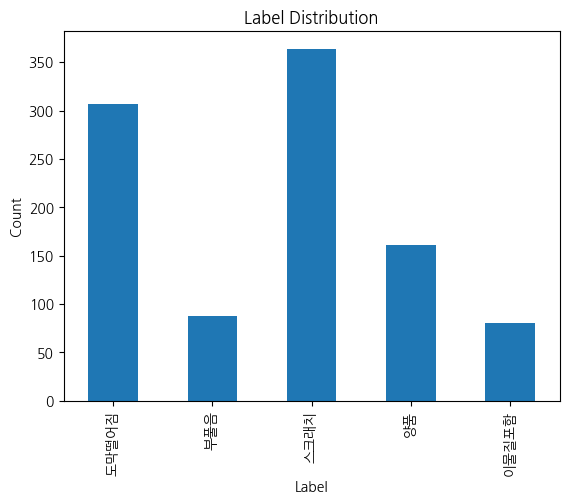

In [35]:
df_submit['label'].value_counts().sort_index().plot(kind='bar')

# 히스토그램 제목과 축 레이블 설정
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

# 그래프 표시
plt.show()

In [36]:
df_submit['label'].value_counts().sort_index()

label
도막떨어짐    307
부풀음       88
스크래치     364
양품       161
이물질포함     80
Name: count, dtype: int64

<a id="sec-6"></a>
## 6. 결론 및 제언

본 프로젝트를 통해 저희는 다음과 같은 성과를 달성했습니다:

### 성과
- **Arena 방식 개발**로 다양한 접근법을 효율적으로 실험
- **체계적인 Git 전략**으로 안정적인 코드 관리
- **98.90%의 Public Score** 달성 (Public Score: 0.98896)

이번 프로젝트는 **제한된 데이터셋**에서도 적절한 전략과 기법을 통해 높은 성능을 달성할 수 있음을 보여주었습니다. 특히 **팀원 간 경쟁적 협업**과 **체계적인 실험 관리**가 성공의 핵심 요인이었다고 판단됩니다.

## Public Score History
1. Public Score: 0.9867 (Epochs=15, IMG_SIZE=224)
2. Public Score: 0.9838 (Epochs=15, 증강 강화)
3. Public Score: 0.9861 (Epochs=20)
4. Public Score: 0.9924 (IMG_SIZE=384, Epochs=10, 앙상블+TTA)
5. Public Score: 0.9890 (IMG_SIZE=224, Epochs=10, 앙상블+TTA) **리더보드 최종 제출**